# **Learning By Observation - Building AI Models that Learn Through Common Sense**

In this notebook, a simple self-supervised model based off SimCLR (https://arxiv.org/abs/2002.05709) has been implemented. The model is trained on Firefighting Device Detection dataset provided in https://universe.roboflow.com/yaid-pzikt/firefighting-device-detection/dataset/6.
The SimCLR model has been obtained from an implementation based on CIFAR-10 dataset (https://github.com/sthalles/SimCLR/tree/master)

**NOTEBOOK INSTRUCTIONS -**

Before you run the notebook, upload 'optimizer_utils.py' in the notebook directory.

In [ ]:
# Copy data zip files and unzip them
!unzip train.zip -d "./Dataset/"
!unzip valid.zip -d "./Dataset/"
!unzip test.zip -d "./Dataset/"

**Task 1 : Prepare Training Data**



In [30]:
from torchvision import transforms
import torch
import PIL
import torchvision

batch_size = 128
workers = 16
image_size = 32
scale_lower = 0.08
color_dist_s = 1

# Generative 2 views per image
class ContrastiveLearningViewGenerator(object):
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform, multiplier):
        self.base_transform = base_transform
        self.multiplier = multiplier

    def __call__(self, x):
        return [self.base_transform(x) for m in range(self.multiplier)]

def get_color_distortion(s=1.0):
    # s is the strength of color distortion.
    # given from https://arxiv.org/pdf/2002.05709.pdf
    color_jitter = transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
    rnd_color_jitter = transforms.RandomApply([color_jitter], p=0.8)
    rnd_gray = transforms.RandomGrayscale(p=0.2)
    color_distort = transforms.Compose([
        rnd_color_jitter,
        rnd_gray])
    return color_distort

# Transformations to apply for training data
train_transform = transforms.Compose([
            # TODO
            # APPLY Transformations here - RandomResizedCrop, HorizontalFlip, get_color_distortion, GaussianBlur
            # https://pytorch.org/vision/stable/transforms.html

            #Vasundhara: This is what I had which worked
            transforms.RandomHorizontalFlip(p=0.5),
            # Faria: cropping according to the global variable image_Size
            transforms.RandomResizedCrop(image_size),
            transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 0.5)),
            get_color_distortion(),
            transforms.ToTensor()
            ])

multi_view_train_transform = ContrastiveLearningViewGenerator(train_transform, 2)

# Transformations to apply for test data
test_transform = transforms.Compose([
            transforms.ToTensor()
            ])

train_data_dir = './Dataset/train'
test_data_dir = './Dataset/valid'
trainset = torchvision.datasets.ImageFolder(train_data_dir, transform=multi_view_train_transform)
testset = torchvision.datasets.ImageFolder(test_data_dir, transform=test_transform)


train_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size = batch_size,
    shuffle = True,
    num_workers = workers,
    pin_memory = True,
    drop_last = True)

test_loader = torch.utils.data.DataLoader(
    testset,
    batch_size = batch_size,
    shuffle = False,
    num_workers = workers,
    pin_memory = True,
    drop_last = True)

# **Visualize Images**

Labels -  tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,
         3,  4,  5,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  9,  9, 10, 11, 11, 12, 13, 13, 13, 13,
        13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14,
        14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18,
        18, 18])


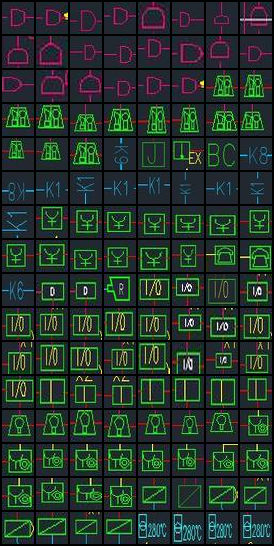

In [32]:
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from IPython.display import Image

# Load one batch of images from test_loader (batch size = 64)
im, labels = next(iter(test_loader))

print("Labels - ", labels)
torchvision.utils.save_image(im, f'clean_{batch_size}_LR3.png')
Image(filename=f'clean_{batch_size}_LR3.png')

**As you can see, the test data we have loaded contains clean images as we have not specified any transformations under test_transform. The corresponding labels to each image are integers. Since the batch size is 64, we get 64 images each time we extract data from the loader.**

Labels -  tensor([27, 20,  0,  6,  1, 13, 22, 27, 37,  6, 14, 25, 16,  1,  7, 13,  7, 26,
        33,  7, 33,  0, 16, 37, 11, 27, 27,  0, 11, 29,  7, 16, 17,  7, 15,  0,
        27,  0, 13, 17, 17,  0,  6, 25, 22,  0, 37,  8, 31, 27, 22, 22, 15,  0,
         1, 33, 35, 37, 11, 13,  1, 35, 13, 33,  7,  0, 31, 35,  3, 38, 22, 17,
        26, 20, 13,  5, 39, 13, 39, 18,  6, 11, 17, 31, 34, 11, 19,  7, 24, 35,
        35,  4, 21, 35,  6,  0, 16, 33, 20, 19, 26, 18, 33, 16, 19, 14, 19,  0,
        35,  0, 13,  8, 14, 22,  0,  0,  0,  1, 15, 35, 13, 17, 34,  1, 14, 27,
        33, 15])


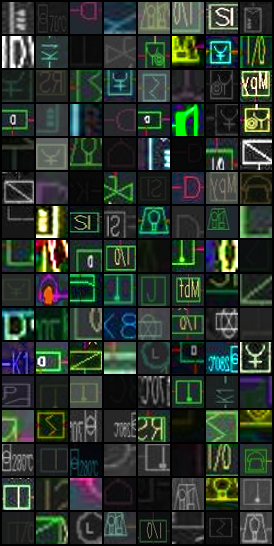

In [33]:
# Load one batch of images from train_loader (batch size = 32)
im, labels = next(iter(train_loader))

print("Labels - ", labels)

# First view
torchvision.utils.save_image(im[0], f'aug1_B{batch_size}_LR3.png')
Image(filename=f'aug1_B{batch_size}_LR3.png')

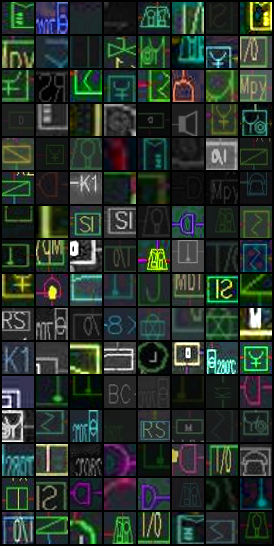

In [34]:
# Second view
torchvision.utils.save_image(im[1], f'aug2_B{batch_size}_LR3.png')
Image(filename=f'aug2_B{batch_size}_LR3.png')

**When you load data from the train_loader, you get two views for every image. As you can see, the views are transformed according to the transformations you have used.**

# **Task 2: Prepare Encoder and Projection Head**

In [35]:
import torch
from torch import nn
import torchvision.models as models

class Encoder(nn.Module):
    def __init__(self, proj_dim):
      super().__init__()

      # ResNet 18 model from pytorch
      self.convnet = models.resnet18(pretrained = False)
      self.encoder_dim = 512
      self.convnet.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
      self.convnet.maxpool = nn.Identity()

      # Delete the last fully connected layer out of ResNet 50 since we only require the features
      self.convnet.fc = nn.Identity()
      self.proj_dim = proj_dim

      # Prepare a Projection Layer
      # Projection Layer has two Linear layers with a ReLU in between.
      # Input dimension = encoder_dim
      # Output dimension = proj_dim
      self.projection = nn.Sequential(
          # https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html
          nn.Linear(self.encoder_dim, self.encoder_dim, bias=False),
          nn.ReLU(),
          nn.Linear(self.encoder_dim, self.proj_dim, bias=False),
      )

    def forward(self, x):
      # Forward propagate the input accoding to SimCLR
      # Compute h and z for a given input.
      h = self.convnet(x)
      z = self.projection(h)
      return h, z

# **Task 3: Implement Contrastive Loss**

In [56]:
import torch.nn as nn
from torch.nn import functional as F
import numpy as np

class SimCLRLoss(nn.Module):
  LARGE_NUMBER = 1e9
  def __init__(self, temperature=0.09):
    super(SimCLRLoss, self).__init__()
    self.temperature = temperature


  # Assume the input z contains 2N features of dimension r
  # The first N features are of the first views of N images
  # The next N features are of the second views of N images
  def forward(self, z, n_views = 2):
    device = torch.device("cuda") if z.is_cuda else torch.device("cpu")

    batch_size = z.shape[0] // n_views

    # Normalize features
    z = F.normalize(z, p = 2, dim = 1)

    # Since we need to compute similarity between different sets of terms for the numerator and denominator
    # It is easier to first compute a similarity matrix of size (2N x 2N). We call this "logits"
    # Then mask out only the cells you need for the numerator and denominator
    logits = torch.div(torch.matmul(z, z.T), self.temperature) # Print this and see what it looks like (all diagonal values should be 1)

    # Stabilization needed for taking log
    logits[np.arange(batch_size * n_views), np.arange(batch_size * n_views)] = -self.LARGE_NUMBER


    # Denominator term
    # Prepare a mask for the denominator term
    # This term compute similarity of a given sample i with all the other samples in the batch (except itself k!=i)
    # This means that the mask should be such that all diagonal cells should be 0 - (i, i) = 0
    self_contrast_mask = (~torch.eye(batch_size * n_views, dtype=torch.bool)).float().to(device)


    # Numerator term
    # Prepare a mask for the matrix
    # The numerator takes similarity of two views of the same image
    # Views of image 0 - 0, N
    # Views of image 1 - 1, N + 1
    # Views of image i - i, N + i
    # Prepare a mask such that only cells (i, N + i), (N + i, i) = 1 and remaining cells are 0
    aug_mask = (torch.eye(batch_size)).repeat(n_views, n_views).to(device)# TODO
    aug_mask = aug_mask * self_contrast_mask


    aug_loss = self.get_loss(logits, aug_mask)
    dataset_loss = self.get_loss(logits, self_contrast_mask)

    maximize_loss = aug_loss - dataset_loss
    loss = -maximize_loss

    return loss

  def get_loss(self, logits, mask):
    exp_logits = torch.exp(logits) * mask
    sum_exp_logits = exp_logits.sum(1)
    loss = torch.log(sum_exp_logits)
    return loss.mean()

In [55]:
loss_obj = SimCLRLoss()

z = torch.randn(64, batch_size)
print('Loss 1:', loss_obj(z)) # This should be high

z = torch.randn(32, batch_size)
# Best case scenario = When represenations of both views are equal
z = torch.cat([z, z])
print('Loss 2:', loss_obj(z)) # This should be low

Loss 1: tensor(4.3965)
Loss 2: tensor(0.0015)


# **Task 4: Train SimCLR Encoder**

In [57]:
encoder = Encoder(proj_dim = batch_size).cuda(0)

In [58]:
from optimizer_utils import get_optimizer_scheduler
import os
cur_iter = 0
iters = 1000
gpu = 0
log_freq = 50

criterion = SimCLRLoss(temperature = 0.1).cuda(gpu)
learningRate = 4
weightDecay = 1e-06
optimizer, scheduler = get_optimizer_scheduler(opt = 'lars',
                                              LR = learningRate,
                                              weight_decay = weightDecay,
                                              lr_schedule = 'warmup-anneal',
                                              warmup = 0.01,
                                              T_max = iters,
                                              model = encoder,
                                              last_epoch=cur_iter-1)


losses = []
checkpoint_dir = "checkpoints"  # Or any directory you prefer
os.makedirs(checkpoint_dir, exist_ok=True) # Create directory if it doesn't exist
while cur_iter < iters:
  for _, batch in enumerate(train_loader):
      cur_iter += 1

      images = batch[0]

      # Concatenate both views into one vector
      images = torch.cat(images).cuda(gpu)

      _, z = encoder(images)
      loss = criterion(z, 2)

      losses.append(loss)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      scheduler.step()

      if (cur_iter % log_freq == 0 or cur_iter == iters):
          print(f'Iter - {cur_iter}, Loss - {loss}')

      if cur_iter == iters:
          break

# Before saving the losses, move them to CPU and convert to NumPy arrays
losses_cpu = [loss.cpu().detach().numpy() for loss in losses]
loss_name = f"simclr_losses_B{batch_size}_LR{learningRate}_WD{weightDecay}_Tmp0p09.npy"
np.save(loss_name, losses_cpu)
# Save the final model (optional, but good practice)
model_name = f"simclr_final_model_B{batch_size}_LR{learningRate}_WD{weightDecay}_Tmp0p09.pth"
final_model_path = os.path.join(checkpoint_dir, model_name)
torch.save(encoder.state_dict(), final_model_path) # Only saves the model weights
print(f"Final model saved at {final_model_path}")

Iter - 50, Loss - 5.305811882019043
Iter - 100, Loss - 5.195261001586914
Iter - 150, Loss - 4.629335403442383
Iter - 200, Loss - 4.434847831726074
Iter - 250, Loss - 4.4216814041137695
Iter - 300, Loss - 4.023380279541016
Iter - 350, Loss - 4.049546241760254
Iter - 400, Loss - 4.049215316772461
Iter - 450, Loss - 3.6349592208862305
Iter - 500, Loss - 3.6379308700561523
Iter - 550, Loss - 3.4281110763549805
Iter - 600, Loss - 3.469736099243164
Iter - 650, Loss - 3.281857490539551
Iter - 700, Loss - 3.5785531997680664
Iter - 750, Loss - 3.1575565338134766
Iter - 800, Loss - 3.2842979431152344
Iter - 850, Loss - 3.086796760559082
Iter - 900, Loss - 2.9983720779418945
Iter - 950, Loss - 2.852466583251953
Iter - 1000, Loss - 3.0715065002441406
Final model saved at checkpoints/simclr_final_model_B128_LR4_WD1e-06_Tmp0p09.pth


# **Verify that the loss is decreasing**

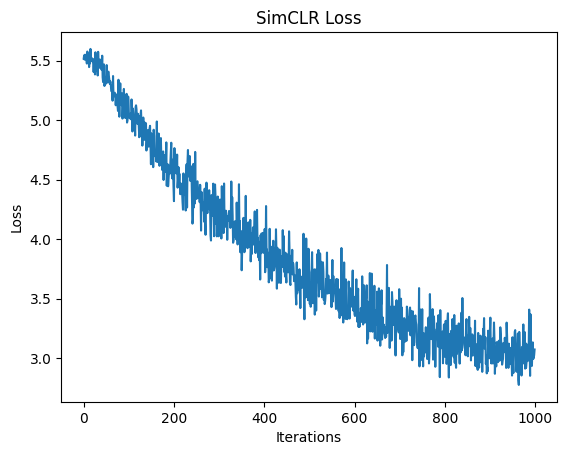

In [59]:
plt.plot(torch.stack(losses).detach().cpu().numpy())
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('SimCLR Loss')
plt_name = f"simCLR_loss_B{batch_size}_LR{learningRate}_WD{weightDecay}_Tmp0p09.png"
plt.savefig(plt_name)
plt.show()